In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import glob
import os
import warnings
from astral import LocationInfo, moon
from astral.sun import sun
from datetime import datetime, timedelta
from datetime import date
warnings.filterwarnings('ignore')

def get_study_site(fp):
    fp = fp.lower()
    if "texas" in fp:
        study_site = "Texas"
    elif "nebraska" in fp:
        study_site = "Nebraska"
    elif "canada" in fp:
        study_site = 'Canada'
    else:
        study_site = "Unknown"
    return study_site

def get_otm(fp):
    csv_name = fp.split('/')[-1]
    otm_name = csv_name.split('_')[0]
    if otm_name == 'AirtempNE22':
        otm_name = 'Air Temperature'
    elif otm_name == 'Air':
        otm_name = 'Air Temperature'
    elif otm_name == 'OTM':
        otm_name = otm_name + csv_name.split('_')[1]
    return otm_name

def get_csv_file_name(fp):
    return fp.split('/')[-1]

def get_microhabitat(csv_name):
    csv_name = csv_name.lower()
    if "open" in csv_name:
        mh = "Open"
    elif "shrub" in csv_name:
        mh = "Shrub"
    elif "halfburrow" in csv_name:
        mh = "Burrow"
    elif "burrow" in csv_name:
        mh = 'Burrow'
    elif "grass" in csv_name:
        mh = 'Grass'
    elif "air" in csv_name:
        mh = 'Air'
    else:
        mh = "Unknown"
    return mh

def get_astronomical_season(row):
    lat = row['Lat']
    lng = row['Long']
    current_date = row['Date']
    
    try:
        city = LocationInfo(name='Custom', region='Custom', timezone='UTC', latitude=lat, longitude=lng)
        year = current_date.year

        # Approximate important dates
        spring_equinox = date(year, 3, 20)
        summer_solstice = date(year, 6, 21)
        fall_equinox = date(year, 9, 22)
        winter_solstice = date(year, 12, 21)
        
        # Determine season
        if spring_equinox <= current_date.date() < summer_solstice:
            return "Spring"
        elif summer_solstice <= current_date.date() < fall_equinox:
            return "Summer"
        elif fall_equinox <= current_date.date() < winter_solstice:
            return "Fall"
        else:
            return "Winter"
    except Exception as e:
        return "Unknown"
    
# Helper function to assign category
def classify_time_moon(row):
    lat = row['Lat']
    lng = row['Long']
    current_time = row['Date']

    try:
        city = LocationInfo(name='Custom', region='Custom', timezone='UTC', latitude=lat, longitude=lng)
        s = sun(city.observer, date=current_time.date())

        # Force Astral times to naive datetimes (remove timezone info)
        s = {k: v.replace(tzinfo=None) for k, v in s.items()}

        # Sun time ranges (give 30-minute windows around events)
        dawn_window = (s['dawn'] - timedelta(minutes=30), s['dawn'] + timedelta(minutes=30))
        sunrise_window = (s['sunrise'] - timedelta(minutes=30), s['sunrise'] + timedelta(minutes=30))
        noon_window = (s['noon'] - timedelta(minutes=30), s['noon'] + timedelta(minutes=30))
        sunset_window = (s['sunset'] - timedelta(minutes=30), s['sunset'] + timedelta(minutes=30))
        dusk_window = (s['dusk'] - timedelta(minutes=30), s['dusk'] + timedelta(minutes=30))

        # Compare naive datetimes
        if dawn_window[0] <= current_time <= dawn_window[1]:
            return 'Dawn'
        elif sunrise_window[0] <= current_time <= sunrise_window[1]:
            return 'Sunrise'
        elif noon_window[0] <= current_time <= noon_window[1]:
            return 'Noon'
        elif sunset_window[0] <= current_time <= sunset_window[1]:
            return 'Sunset'
        elif dusk_window[0] <= current_time <= dusk_window[1]:
            return 'Dusk'

        # Else, check moon phase
        # Check moon phase
        phase = moon.phase(current_time.date())
        if phase < 1 or phase > 28:
            return 'NewMoon'
        elif 1 <= phase < 6:
            return 'WaxingCrescent'
        elif 6 <= phase < 8:
            return 'FirstQuarter'
        elif 8 <= phase < 14:
            return 'WaxingGibbous'
        elif 14 <= phase < 16:
            return 'FullMoon'
        elif 16 <= phase < 21:
            return 'WaningGibbous'
        elif 21 <= phase < 23:
            return 'LastQuarter'
        elif 23 <= phase < 28:
            return 'WaningCrescent'
        else:
            return 'Unknown'


    except Exception as e:
        return 'Unknown'
    
def classify_day_period(row):
    lat = row['Lat']
    lng = row['Long']
    current_time = row['Date']

    try:
        city = LocationInfo(name='Custom', region='Custom', timezone='UTC', latitude=lat, longitude=lng)
        s = sun(city.observer, date=current_time.date())

        # Force Astral times to naive
        s = {k: v.replace(tzinfo=None) for k, v in s.items()}

        # Compare
        if s['dawn'] <= current_time < s['sunrise']:
            return 'Dawn'
        elif s['sunrise'] <= current_time < s['sunset']:
            return 'Day'
        elif s['sunset'] <= current_time < s['dusk']:
            return 'Dusk'
        else:
            return 'Night'

    except Exception as e:
        return 'Unknown'
    
def assign_meteorological_season(row):
    month = row['Date'].month

    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
    

def study_site_key(site_name):
    """
    Dummy codes study sites into numeric codes:
    - Canada -> 1
    - Nebraska -> 2
    - Texas -> 3

    Parameters:
    - site_name: string (Study_Site)

    Returns:
    - int (dummy code)
    """
    site_mapping = {
        'Canada': 1,
        'Nebraska': 2,
        'Texas': 3
    }
    return site_mapping.get(site_name, np.nan)  # returns NaN if site_name not recognized

    
data_folders = ['/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Canada/OTM_Data_Canada_2022/',
                '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Canada/OTM_Data_Canada_2023/',
                '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Nebraska/',
                '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Nebraska/OTM_Data_Nebraska_23_24/',
                '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Nebraska/OTM_Nebraska_24_25/',
                #'/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Texas/Marathon/OTM_Offload_day_07302021',
                '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Texas/Marathon/OTM_DATA_MG_2021/',
                '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Data_202504/OTM_Data/Texas/Marathon/OTM_DATA_MG_2023_2024/'
                ]

Canada_lat_lng = (50.849182, -110.051823)
Nebraska_lat_lng = (42.797940, -100.127796)
Texas_lat_lng = (30.322706, -103.136333)

# Make DB
Canada_lat_lng = (50.849182, -110.051823)
Nebraska_lat_lng = (42.797940, -100.127796)
Texas_lat_lng = (30.322706, -103.136333)
otm_main = pd.DataFrame()
for folder in data_folders:
    csv_files = glob.glob(folder + "*.csv")
    for csv_file in csv_files:
        col_names = ['Date', 'Unit', 'Temperature']
        temp_df = pd.read_csv(csv_file,names = col_names, skiprows=20, header=None)
        temp_df['Date'] = pd.to_datetime(temp_df['Date']) 
        temp_df['year'] = temp_df['Date'].dt.year
        temp_df['month'] = temp_df['Date'].dt.month
        temp_df['day'] = temp_df['Date'].dt.day
        temp_df['hour'] = temp_df['Date'].dt.hour
        temp_df['minute'] = temp_df['Date'].dt.minute
        temp_df['Study_Site'] = [get_study_site(folder) for i in range(len(temp_df))]
        temp_df['Microhabitat'] = [get_microhabitat(csv_file) for i in range(len(temp_df))]
        temp_df['OTM_ID'] = [get_otm(csv_file) for i in range(len(temp_df))]
        temp_df['file_name'] = [get_csv_file_name(csv_file) for i in range(len(temp_df))]
        otm_main = pd.concat([otm_main, temp_df], ignore_index=True)

# Add Lat and Long to each Study_Site
site_coords = {
    'Canada': Canada_lat_lng,
    'Nebraska': Nebraska_lat_lng,
    'Texas': Texas_lat_lng
}

# Map Lat and Long into your DataFrame
otm_main['Lat'] = otm_main['Study_Site'].map(lambda x: site_coords.get(x, (np.nan, np.nan))[0])
otm_main['Long'] = otm_main['Study_Site'].map(lambda x: site_coords.get(x, (np.nan, np.nan))[1])

# Now apply your helper functions to create the new columns
otm_main['Astronomical_Season'] = otm_main.apply(get_astronomical_season, axis=1)
otm_main['SunMoon_Category'] = otm_main.apply(classify_time_moon, axis=1)
otm_main['Simple_DayPeriod'] = otm_main.apply(classify_day_period, axis=1)
otm_main['Meteorological_Season'] = otm_main.apply(assign_meteorological_season, axis=1)


In [2]:
def study_site_key(site_name):
    """
    Dummy codes study sites into numeric codes:
    - Canada -> 1
    - Nebraska -> 2
    - Texas -> 3

    Parameters:
    - site_name: string (Study_Site)

    Returns:
    - int (dummy code)
    """
    site_mapping = {
        'Canada': 1,
        'Nebraska': 2,
        'Texas': 3
    }
    return site_mapping.get(site_name, np.nan)  # returns NaN if site_name not recognized

otm_main['Study_Site_Code'] = otm_main['Study_Site'].apply(study_site_key)




In [3]:
otm_main.head()

,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,Microhabitat,OTM_ID,file_name,Lat,Long,Astronomical_Season,SunMoon_Category,Simple_DayPeriod,Meteorological_Season,Study_Site_Code
0,2022-06-17 23:00:01,C,17.663,2022,6,17,23,0,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv,50.849182,-110.051823,Spring,WaningGibbous,Night,Summer,1
1,2022-06-18 00:10:01,C,17.663,2022,6,18,0,10,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv,50.849182,-110.051823,Spring,WaningGibbous,Night,Summer,1
2,2022-06-18 01:20:01,C,17.163,2022,6,18,1,20,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv,50.849182,-110.051823,Spring,WaningGibbous,Night,Summer,1
3,2022-06-18 02:30:01,C,17.163,2022,6,18,2,30,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv,50.849182,-110.051823,Spring,WaningGibbous,Night,Summer,1
4,2022-06-18 03:40:01,C,16.662,2022,6,18,3,40,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv,50.849182,-110.051823,Spring,Sunset,Dusk,Summer,1


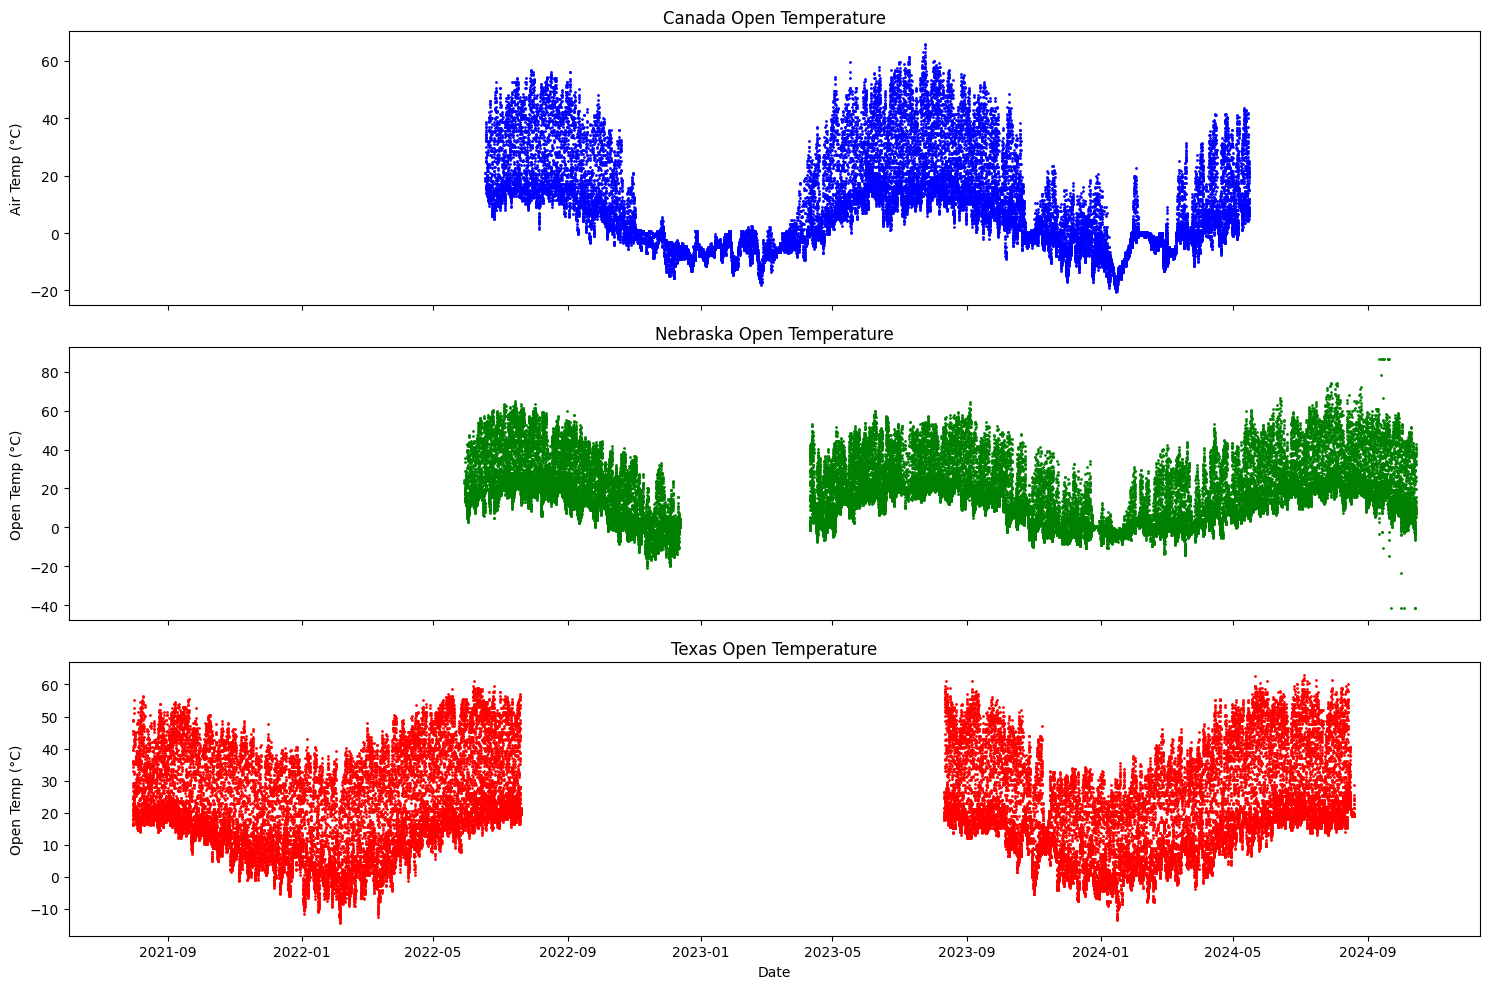

In [13]:
canada_df = otm_main[otm_main['Study_Site'] == 'Canada'].sort_values('Date').reset_index(drop=True)
nebraska_df = otm_main[otm_main['Study_Site'] == 'Nebraska'].sort_values('Date').reset_index(drop=True)
texas_df = otm_main[otm_main['Study_Site'] == 'Texas'].sort_values('Date').reset_index(drop=True)


fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

canada_open = canada_df[canada_df['Microhabitat'] == 'Open'].sort_values('Date').reset_index(drop=True)
nebraska_open = nebraska_df[nebraska_df['Microhabitat'] == 'Open'].sort_values('Date').reset_index(drop=True)
texas_open = texas_df[texas_df['Microhabitat'] == 'Open'].sort_values('Date').reset_index(drop=True)

# Plot air temperatures
axes[0].scatter(canada_open['Date'], canada_open['Temperature'], label='Canada', color='blue', s=1)
axes[0].set_ylabel("Air Temp (°C)")
axes[0].set_title("Canada Open Temperature")

axes[1].scatter(nebraska_open['Date'], nebraska_open['Temperature'], label='Nebraska', color='green', s=1)
axes[1].set_ylabel("Open Temp (°C)")
axes[1].set_title("Nebraska Open Temperature")

axes[2].scatter(texas_open['Date'], texas_open['Temperature'], label='Texas', color='red', s=1)
axes[2].set_ylabel("Open Temp (°C)")
axes[2].set_title("Texas Open Temperature")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

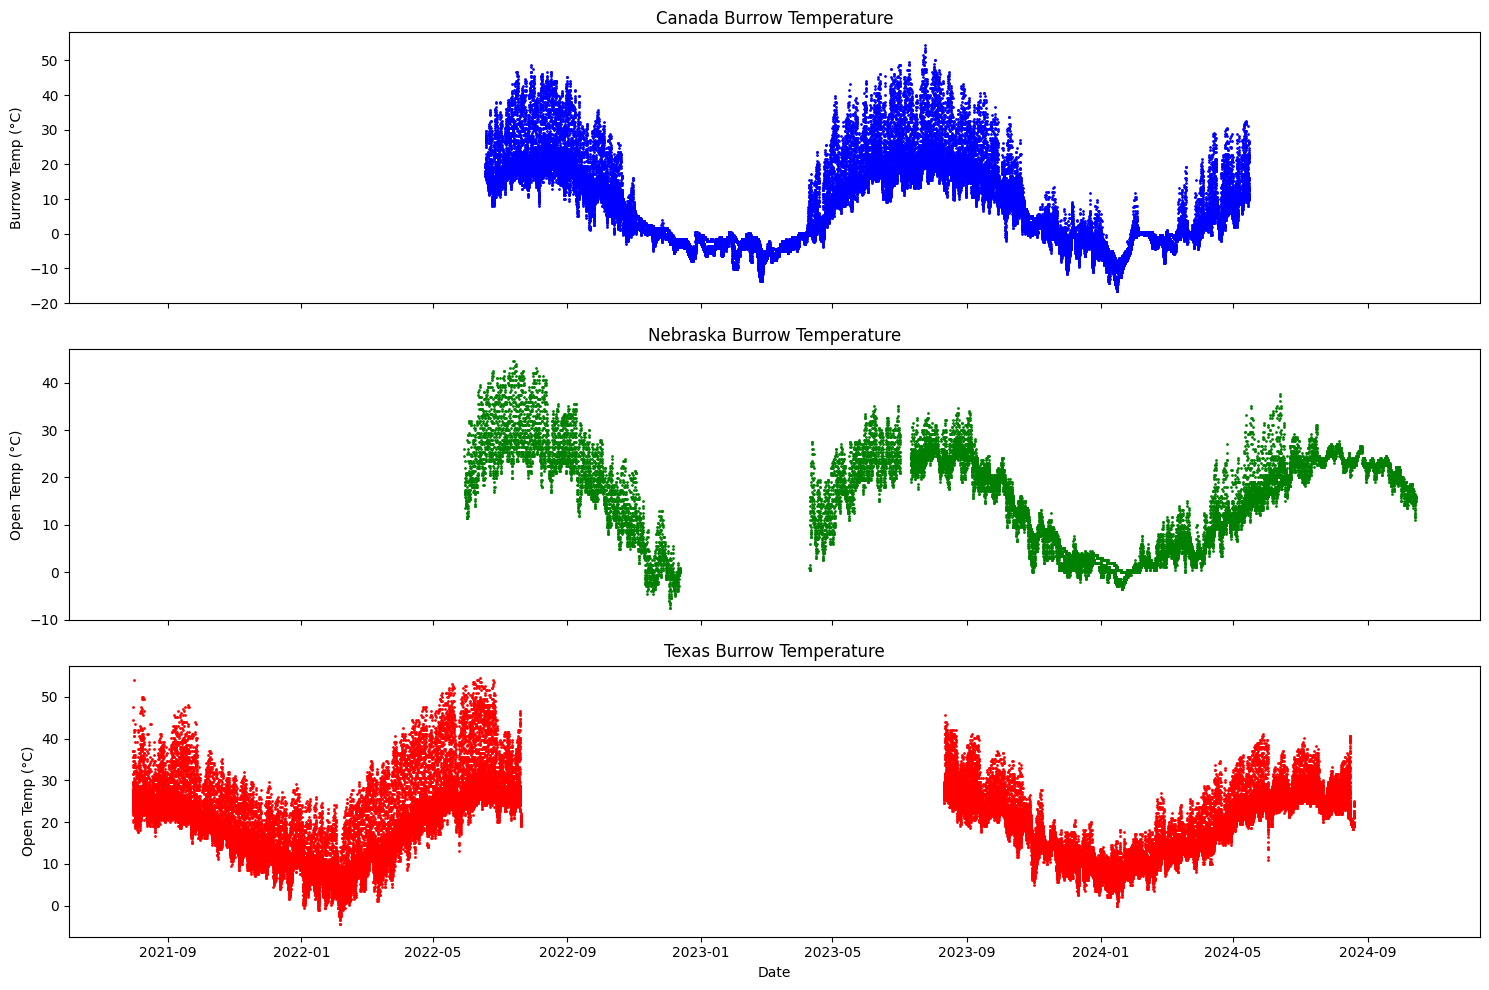

In [14]:
# Burrow temperatures figure
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

canada_burrow = canada_df[canada_df['Microhabitat'] == 'Burrow'].sort_values('Date').reset_index(drop=True)
nebraska_burrow = nebraska_df[nebraska_df['Microhabitat'] == 'Burrow'].sort_values('Date').reset_index(drop=True)
texas_burrow = texas_df[texas_df['Microhabitat'] == 'Burrow'].sort_values('Date').reset_index(drop=True)

# Plot air temperatures
axes[0].scatter(canada_burrow['Date'], canada_burrow['Temperature'], label='Canada', color='blue', s=1)
axes[0].set_ylabel("Burrow Temp (°C)")
axes[0].set_title("Canada Burrow Temperature")

axes[1].scatter(nebraska_burrow['Date'], nebraska_burrow['Temperature'], label='Nebraska', color='green', s=1)
axes[1].set_ylabel("Open Temp (°C)")
axes[1].set_title("Nebraska Burrow Temperature")

axes[2].scatter(texas_burrow['Date'], texas_burrow['Temperature'], label='Texas', color='red', s=1)
axes[2].set_ylabel("Open Temp (°C)")
axes[2].set_title("Texas Burrow Temperature")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

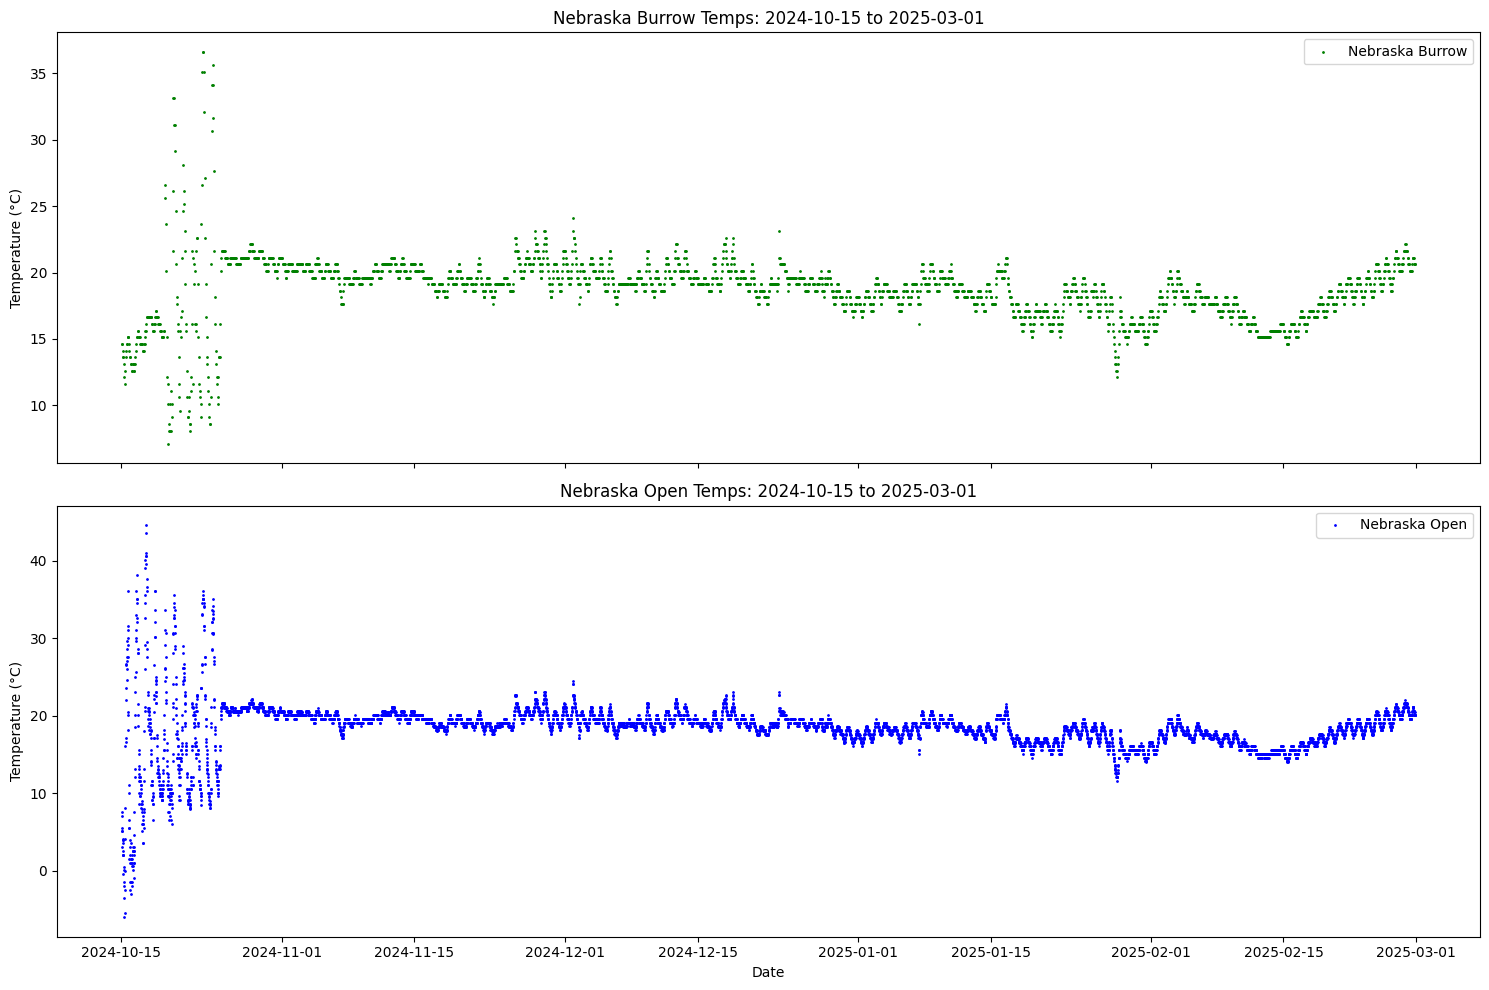

In [ ]:
# Nebraska cleanup
# Bad Date ranges 
# Nebraska: 2022-12-13 to 2023-04-10
# Nebraska: '2024-10-15' greater
import matplotlib.pyplot as plt

# --- Date Ranges ---
start_date = '2024-10-15'
end_date   = '2025-03-01'

# --- Filter Conditions ---
filter_conditions = {
    'Nebraska': {
        "Burrow": {'start': start_date, 'end': end_date},
        "Open": {'start': start_date, 'end': end_date}
    }
}

# --- Filter the DataFrames ---
burrow_mask = (nebraska_burrow['Date'] >= start_date) & (nebraska_burrow['Date'] <= end_date)
open_mask   = (nebraska_open['Date'] >= start_date) & (nebraska_open['Date'] <= end_date)

filtered_burrow = nebraska_burrow.loc[burrow_mask]
filtered_open   = nebraska_open.loc[open_mask]

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Burrow Temps
axes[0].scatter(filtered_burrow['Date'], filtered_burrow['Temperature'], color='green', s=1, label='Nebraska Burrow')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title(f"Nebraska Burrow Temps: {start_date} to {end_date}")
axes[0].legend()

# Open Temps
axes[1].scatter(filtered_open['Date'], filtered_open['Temperature'], color='blue', s=1, label='Nebraska Open')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_title(f"Nebraska Open Temps: {start_date} to {end_date}")
axes[1].legend()

plt.tight_layout()
plt.show()

#plt.scatter(nebraska_burrow['Date'], nebraska_burrow['Temperature'], label='Nebraska', color='green', s=1)

## Make DB

In [11]:
#Filter bad dates
# Nebraska: 2022-12-13 to 2023-04-10
# Nebraska: '2024-10-15' greater
bad_start = pd.to_datetime('2022-12-13')
bad_end   = pd.to_datetime('2023-04-10')
bad_cutoff = pd.to_datetime('2024-10-15')

# Create a mask that excludes the bad date ranges for Nebraska
mask = ~(
    ((otm_main['Study_Site'] == 'Nebraska') &
     ((otm_main['Date'] >= bad_start) & (otm_main['Date'] <= bad_end)))
    |
    ((otm_main['Study_Site'] == 'Nebraska') &
     (otm_main['Date'] > bad_cutoff))
)

# Apply the mask directly to otm_main
otm_main = otm_main[mask]

In [15]:
otm_main.to_csv('/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Main_Database.csv', index=False)

In [ ]:
# Make DB
Canada_lat_lng = (50.849182, -110.051823)
Nebraska_lat_lng = (42.797940, -100.127796)
Texas_lat_lng = (30.322706, -103.136333)
otm_main = pd.DataFrame()
for folder in data_folders:
    csv_files = glob.glob(folder + "*.csv")
    for csv_file in csv_files:
        col_names = ['Date', 'Unit', 'Temperature']
        temp_df = pd.read_csv(csv_file,names = col_names, skiprows=20, header=None)
        temp_df['Date'] = pd.to_datetime(temp_df['Date']) 
        temp_df['year'] = temp_df['Date'].dt.year
        temp_df['month'] = temp_df['Date'].dt.month
        temp_df['day'] = temp_df['Date'].dt.day
        temp_df['hour'] = temp_df['Date'].dt.hour
        temp_df['minute'] = temp_df['Date'].dt.minute
        temp_df['Study_Site'] = [get_study_site(folder) for i in range(len(temp_df))]
        temp_df['Microhabitat'] = [get_microhabitat(csv_file) for i in range(len(temp_df))]
        temp_df['OTM_ID'] = [get_otm(csv_file) for i in range(len(temp_df))]
        temp_df['file_name'] = [get_csv_file_name(csv_file) for i in range(len(temp_df))]
        otm_main = pd.concat([otm_main, temp_df], ignore_index=True)

In [31]:
otm_main.head()

,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,Microhabitat,OTM_ID,file_name
0,2022-06-17 23:00:01,C,17.663,2022,6,17,23,0,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv
1,2022-06-18 00:10:01,C,17.663,2022,6,18,0,10,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv
2,2022-06-18 01:20:01,C,17.163,2022,6,18,1,20,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv
3,2022-06-18 02:30:01,C,17.163,2022,6,18,2,30,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv
4,2022-06-18 03:40:01,C,16.662,2022,6,18,3,40,Canada,Burrow,OTM8,OTM8_burrow_CAN_2022.csv


In [33]:
unique_combinations = otm_main[['Study_Site', 'Microhabitat']].drop_duplicates()
print(unique_combinations)

       Study_Site Microhabitat
0          Canada       Burrow
14304      Canada          Air
21456      Canada         Open
35760      Canada         Half
50064      Canada        Shrub
158066   Nebraska        Shrub
166258   Nebraska         Open
174450   Nebraska          Air
199026   Nebraska         Half
245010   Nebraska       Burrow
294965      Texas       Burrow
310385      Texas         Open
325805      Texas          Air
364835      Texas        Shrub
